In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from skimage.feature import graycomatrix, graycoprops 
from pipelines.segment_bright_image import segment_bright_image
from pipelines.segment_flat_image import segment_flat_image
from pipelines.segment_dark_image import segment_dark_image
from eval import eval

## Análisis Exploratorio de Datos


Mostrando 3 imágenes en escala de grises...


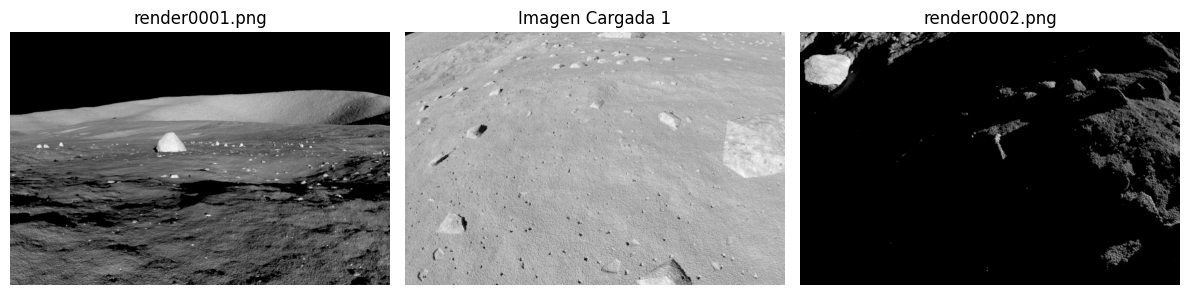


Mostrando histogramas para 3 imágenes (con escala Y unificada)...


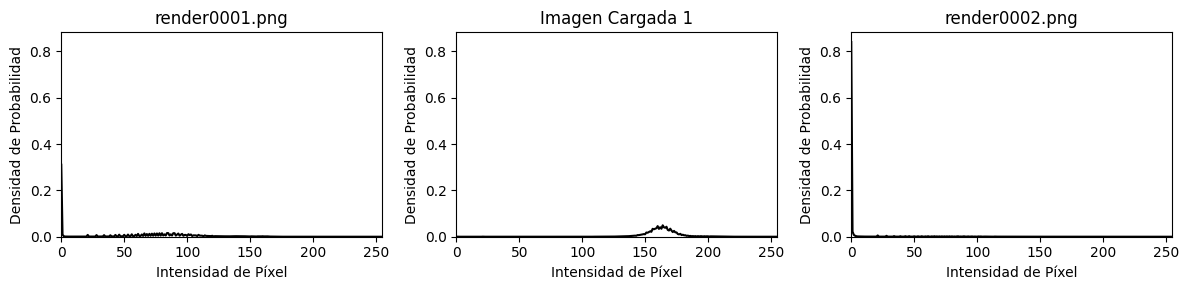


--- Estadísticas Básicas ---
render0001.png: Media = 57.86, Desv. Est. = 48.28
Imagen Cargada 1: Media = 162.74, Desv. Est. = 16.09
render0002.png: Media = 9.48, Desv. Est. = 30.58

--- Características GLCM ---
render0001.png:
  Contrast: 357.6116
  Dissimilarity: 10.4929
  Homogeneity: 0.3694
Imagen Cargada 1:
  Contrast: 307.2287
  Dissimilarity: 10.9208
  Homogeneity: 0.1151
render0002.png:
  Contrast: 396.6294
  Dissimilarity: 5.8838
  Homogeneity: 0.8304

--- Análisis de Fourier ---
Calculando y mostrando los espectros de magnitud de Fourier...


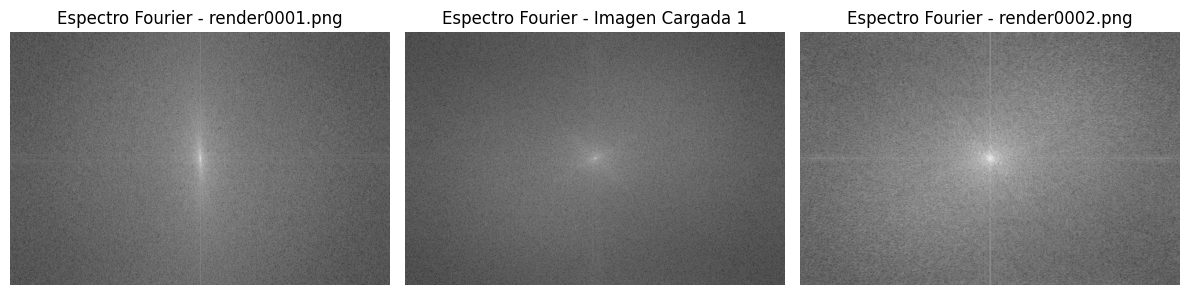

In [3]:



def plot_images_grid(images, titles=None, cols=5):
    if not images or all(img is None for img in images):
        print("No hay imágenes válidas para mostrar en la grilla.")
        return
    
    valid_images_data = []
    if titles:
        for img, title in zip(images, titles):
            if img is not None:
                valid_images_data.append({'image': img, 'title': title})
    else:
        for img in images:
            if img is not None:
                valid_images_data.append({'image': img, 'title': None})

    if not valid_images_data:
        print("No hay imágenes válidas para mostrar en la grilla después del filtrado.")
        return

    num_valid_images = len(valid_images_data)
    rows = int(np.ceil(num_valid_images / cols))
    fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axs = axs.flatten() 
    
    for i, data in enumerate(valid_images_data):
        axs[i].imshow(data['image'], cmap='gray')
        axs[i].axis('off')
        if data['title']:
            axs[i].set_title(data['title'])
            
    for j in range(num_valid_images, len(axs)):
        axs[j].axis('off')
        
    plt.tight_layout()
    plt.show()

def load_grayscale_images(image_paths):
    images = []
    for path in image_paths:
        try:
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                print(f"Advertencia: No se pudo cargar la imagen {os.path.basename(path)}. Verifique la ruta o el archivo.")
            images.append(image)
        except Exception as e:
            print(f"Error cargando la imagen {os.path.basename(path)}: {e}")
            images.append(None)
    return images

def load_first_n_grayscale_images(folder_path, n=5, extension='*.png'):
    image_paths = sorted(glob.glob(os.path.join(folder_path, extension)))
    if not image_paths:
        print(f"No se encontraron imágenes con la extensión '{extension}' en la carpeta '{folder_path}'.")
        return []
    selected_paths = image_paths[:n]
    return load_grayscale_images(selected_paths)


def plot_histograms_grid(images, titles=None, cols=5):
    if not images or all(img is None for img in images):
        print("No hay imágenes válidas para mostrar histogramas.")
        return

    valid_images_data = []
    if titles:
        for img, title in zip(images, titles):
            if img is not None:
                valid_images_data.append({'image': img, 'title': title})
    else:
        for img in images:
            if img is not None:
                valid_images_data.append({'image': img, 'title': None})
    
    if not valid_images_data:
        print("No hay imágenes válidas para mostrar histogramas después del filtrado.")
        return

    num_valid_images = len(valid_images_data)
    rows = int(np.ceil(num_valid_images / cols))
    fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axs = axs.flatten()

    max_density_overall = 0
    calculated_histograms = []

    for data in valid_images_data:
        image = data['image']
        hist, bins = np.histogram(image.ravel(), bins=256, range=(0, 256), density=True)
        calculated_histograms.append({'hist': hist, 'bins': bins[:-1], 'title': data['title']})
        current_max_density = np.max(hist)
        if current_max_density > max_density_overall:
            max_density_overall = current_max_density

    y_axis_upper_limit = max_density_overall * 1.05 
    if y_axis_upper_limit == 0: 
        y_axis_upper_limit = 0.01

    for i, hist_data in enumerate(calculated_histograms):
        ax = axs[i]
        hist = hist_data['hist']
        bins = hist_data['bins']
        
        ax.plot(bins, hist, color='black')
        ax.set_xlim([0, 255])
        ax.set_ylim(0, y_axis_upper_limit)
        ax.set_xlabel('Intensidad de Píxel')
        ax.set_ylabel('Densidad de Probabilidad')
        if hist_data['title']:
            ax.set_title(hist_data['title'])

    for j in range(num_valid_images, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()


def calcular_y_mostrar_estadisticas_basicas(imagenes, titulos):
    print("\n--- Estadísticas Básicas ---")
    if not imagenes:
        print("No hay imágenes para calcular estadísticas.")
        return
    for i, imagen in enumerate(imagenes):
        titulo_actual = titulos[i] if titulos and i < len(titulos) else f"Imagen {i+1}"
        if imagen is not None:
            media = np.mean(imagen)
            desv_est = np.std(imagen)
            print(f"{titulo_actual}: Media = {media:.2f}, Desv. Est. = {desv_est:.2f}")
        else:
            print(f"{titulo_actual}: No disponible (imagen es None)")

def calcular_y_mostrar_features_glcm(imagenes, titulos, distancias=[5], angulos=[0], propiedades=None):
    print("\n--- Características GLCM ---")
    if propiedades is None:
        propiedades = ['contrast', 'dissimilarity', 'homogeneity']
    
    if not imagenes:
        print("No hay imágenes para calcular características GLCM.")
        return

    for i, imagen in enumerate(imagenes):
        titulo_actual = titulos[i] if titulos and i < len(titulos) else f"Imagen {i+1}"
        if imagen is not None:
            print(f"{titulo_actual}:")
            
            img_glcm = imagen
            if imagen.dtype != np.uint8: # Asegurar que la imagen sea uint8 para GLCM
                if np.max(imagen) <= 1.0 and imagen.min() >= 0.0: # Posiblemente flotante en [0,1]
                    img_glcm = (imagen * 255).astype(np.uint8)
                elif np.max(imagen) > 255 or imagen.min() < 0: # Necesita normalización
                    print(f"  Advertencia: La imagen {titulo_actual} no es uint8 estándar. Se normalizará a uint8.")
                    img_norm = cv2.normalize(imagen, None, 0, 255, cv2.NORM_MINMAX)
                    img_glcm = img_norm.astype(np.uint8)
                else: # Otro tipo numérico pero en rango [0,255]
                    img_glcm = imagen.astype(np.uint8)

            if np.ptp(img_glcm) == 0: # Imagen plana (todos los píxeles iguales)
                print("  Imagen con Rango Dinámico Cero. Omitiendo GLCM.")
                for prop in propiedades:
                    print(f"  {prop.capitalize()}: N/A")
                continue
            
            try:
                glcm = graycomatrix(img_glcm,
                                    distances=distancias,
                                    angles=angulos,
                                    levels=256,
                                    symmetric=True,
                                    normed=True)
                
                for prop in propiedades:
                    valor_feature = graycoprops(glcm, prop)
                    print(f"  {prop.capitalize()}: {np.mean(valor_feature):.4f}")
            except Exception as e:
                print(f"  Error calculando GLCM para {titulo_actual}: {e}")
        else:
            print(f"{titulo_actual}: No disponible (imagen es None)")

def calcular_espectros_fourier(imagenes):
    espectros_fourier = []
    if not imagenes:
        return espectros_fourier
        
    for imagen in imagenes:
        if imagen is not None:
            f = np.fft.fft2(imagen)
            fshift = np.fft.fftshift(f)
            magnitud_espectro = np.log1p(np.abs(fshift)) 
            espectros_fourier.append(magnitud_espectro)
        else:
            espectros_fourier.append(None) 
    return espectros_fourier

if __name__ == "__main__":
    folder_path = './dataset/images/render' 
    num_images_to_load = 3
    extension_busqueda = '*.png'

    raw_images_grayscale = load_first_n_grayscale_images(folder_path, n=num_images_to_load, extension=extension_busqueda)

    processed_images = []
    processed_titles = []

    if raw_images_grayscale: 
        all_image_paths_in_folder = sorted(glob.glob(os.path.join(folder_path, extension_busqueda)))
        paths_for_loaded_images_attempted = all_image_paths_in_folder[:num_images_to_load]

        for i, img in enumerate(raw_images_grayscale):
            if img is not None:
                processed_images.append(img)
                if i < len(paths_for_loaded_images_attempted):
                    processed_titles.append(f'{os.path.basename(paths_for_loaded_images_attempted[i])}')
                    processed_titles.append(f'Imagen Cargada {len(processed_images)}')

    if processed_images:
        display_cols = min(num_images_to_load, len(processed_images), 3)
        if display_cols == 0: display_cols = 1 

        print(f"\nMostrando {len(processed_images)} imágenes en escala de grises...")
        plot_images_grid(processed_images, titles=processed_titles, cols=display_cols)

        print(f"\nMostrando histogramas para {len(processed_images)} imágenes (con escala Y unificada)...")
        plot_histograms_grid(processed_images, titles=processed_titles, cols=display_cols)

        calcular_y_mostrar_estadisticas_basicas(processed_images, processed_titles)

        calcular_y_mostrar_features_glcm(processed_images, processed_titles)

        print("\n--- Análisis de Fourier ---")
        print("Calculando y mostrando los espectros de magnitud de Fourier...")
        espectros_fourier = calcular_espectros_fourier(processed_images)
        
        if any(s is not None for s in espectros_fourier):
            titulos_fourier = [f"Espectro Fourier - {title}" for title in processed_titles]
            plot_images_grid(espectros_fourier, titles=titulos_fourier, cols=display_cols)
        else:
            print("No se generaron espectros de Fourier para mostrar.")
            
    else:
        print(f"No se cargaron imágenes válidas desde '{folder_path}' para procesar.")

## Desarrollo

### Plot de máscara 14 procesada

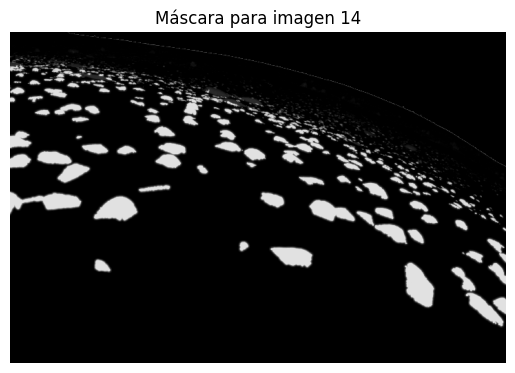

In [4]:
from remove_red import remove_red
def eval(image_number):
    formated_num = str(image_number).zfill(4)
    
    # Read the image
    image_path = f"dataset/images/render/render{formated_num}.png"
    mask_path = f"dataset/images/ground/ground{formated_num}.png"

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Read image in rgb, remove all red pixels and convert to grayscale
    mask = cv2.imread(mask_path, cv2.COLOR_BGR2RGB)
    mask = remove_red(mask)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    if image is None or mask is None:
        raise FileNotFoundError(
            f"Image or mask not found for image number {formated_num}"
        )

    return mask


if __name__ == "__main__":
    image_number = 14
    try:
        mask = eval(image_number)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Máscara para imagen {image_number}')
        plt.axis('off')
        plt.show()
    except FileNotFoundError as e:
        print(e)

### Resultados

#### Ploteador de Imagen segun busqueda de loss

In [ ]:
from eval import eval

if __name__ == "__main__":
    for image_number in range(1,1000):
        formated_num = str(image_number).zfill(4)
        image_path = f"dataset/images/render/render{formated_num}.png"
        real_mask_path = f"dataset/images/ground/ground{formated_num}.png"

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        real_mask = cv2.imread(real_mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or real_mask is None:
            continue

        try:
            _, loss_bright = eval(formated_num, segment_bright_image)
            _, loss_flat = eval(formated_num, segment_flat_image)
            _, loss_dark = eval(formated_num, segment_dark_image)

            loss_bright = (100-loss_bright)
            loss_flat = (100-loss_flat) 
            loss_dark = (100-loss_dark) 

        except Exception as e:
            print(f"Error al evaluar {formated_num}: {e}")
            continue

        if all(loss < 50 for loss in [loss_bright, loss_flat, loss_dark]):
            mask_bright = segment_bright_image(image)
            mask_flat = segment_flat_image(image)
            mask_dark = segment_dark_image(image)

            images_to_plot = [image, real_mask, mask_bright, mask_flat, mask_dark]
            titles = [
                f'Imagen Original: render{formated_num}.png',
                'Máscara Real',
                f'Segmentación Brillante - Precisión: {loss_bright:.1f}%',
                f'Segmentación Plana - Precisión: {loss_flat:.1f}%',
                f'Segmentación Oscura - Precisión: {loss_dark:.1f}%'
            ]
            plot_images_grid(images_to_plot, titles=titles, cols=3)

            break  


KeyboardInterrupt: 

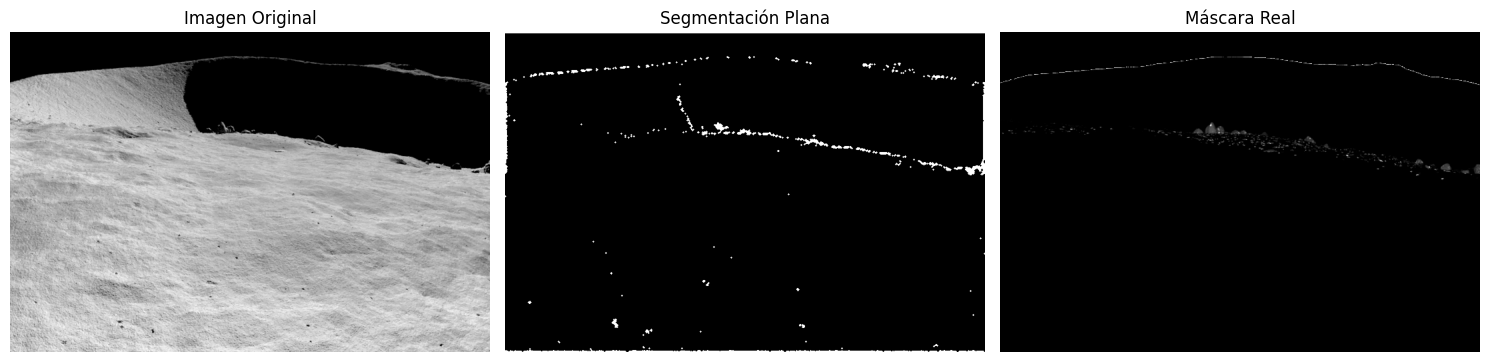

In [15]:
image_number = '0104'
img = cv2.imread(f"dataset/images/render/render{image_number}.png", cv2.IMREAD_GRAYSCALE)
mask = segment_flat_image(img)

real_mask = cv2.imread(f"dataset/images/ground/ground{image_number}.png", cv2.COLOR_BGR2RGB)
real_mask = remove_red(real_mask)
real_mask = cv2.cvtColor(real_mask, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Segmentación Plana')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(real_mask, cmap='gray')
plt.title('Máscara Real')
plt.axis('off')
plt.tight_layout()
plt.show()


#### Imagen con Piedra Vacía Dentro

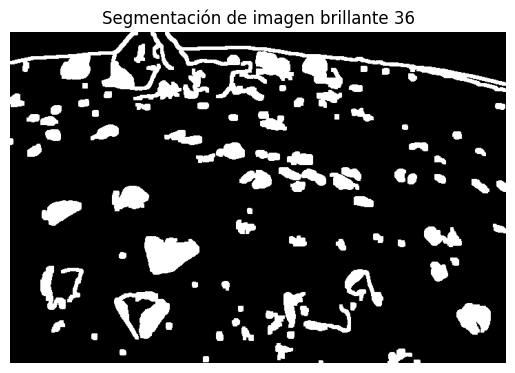

In [ ]:
# Load render 36

if __name__ == "__main__":
    image_number = 36
    formated_num = str(image_number).zfill(4)
    
    # Read the image
    image_path = f"dataset/images/render/render{formated_num}.png"
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        raise FileNotFoundError(f"Image not found for image number {formated_num}")

    # Segment the bright regions
    segmented_image = segment_bright_image(image)

    plt.imshow(segmented_image, cmap='gray')
    plt.title(f'Segmentación de imagen brillante {image_number}')
    plt.axis('off')
    plt.show()